## Model Selection Workflow

In this tutorial we create three model alternatives using a PyCoTools wrapper around tellurium and antimony. Data is simualted from the negative feedback model and used in a model selection problem to distinguish between three model candidates. To perform model selection using PyCoTools, all models and data files should be placed into a new directory. Data files should conform to the same format that the COPASI GUI requires with the addition that the headers must match model variables exactly (or have the suffix `_indep` for independent variables). The `tasks.MultiModelFit` class detects COPASI and data files in the folder and sets up a multi-parameter estimation for each using the `tasks.MultiParameterEstimation` class. After fitting, the `viz.ModelSelection` class is used to calculate AIC and BIC and to plot model selection criteria. 

In [ ]:
import os, glob
import site
site.addsitedir('/home/b3053674/Documents/pycotools')
from pycotools import model, tasks, viz, misc
import seaborn
%matplotlib inline
seaborn.set_context('notebook')

working_directory = r'/home/b3053674/Documents/Models/2018/'\
                     '03_March/ModelSelectionDemonstration'

## create directory for our model selection analysis
model_selection_dir = os.path.join(working_directory, 'ModelSelection')

if not os.path.isdir(model_selection_dir):
    os.makedirs(model_selection_dir)
    
## create paths to three model alternatives. 
## This should be inside a new clean directory
copasi_file1 = os.path.join(model_selection_dir, 'negative_feedback.cps')
copasi_file2 = os.path.join(model_selection_dir, 'positive_feedback.cps')
copasi_file3 = os.path.join(model_selection_dir, 'feedforward.cps')

## build models with antimony
with model.BuildAntimony(copasi_file1) as loader:
    mod1 = loader.load(
        """
        model negative_feedback
            compartment cell = 1.0
            var A in cell
            var B in cell

            vAProd = 0.1
            kADeg = 0.2
            kBProd = 0.3
            kBDeg = 0.4
            A = 0
            B = 0

            AProd: => A; cell*vAProd
            ADeg: A =>; cell*kADeg*A*B
            BProd: => B; cell*kBProd*A
            BDeg: B => ; cell*kBDeg*B
        end
        """
    )

with model.BuildAntimony(copasi_file2) as loader:
    mod2 = loader.load(
        """
        model positive_feedback
            compartment cell = 1.0
            var A in cell
            var B in cell

            vAProd = 0.1
            kADeg = 0.2
            kBProd = 0.3
            kBDeg = 0.4
            vBasalAProd = 0.001
            A = 0
            B = 0

            AProd: => A; cell*vAProd*B+vBasalAProd
            ADeg: A =>; cell*kADeg*A
            BProd: => B; cell*kBProd*A
            BDeg: B => ; cell*kBDeg*B
        end
        """
    )

with model.BuildAntimony(copasi_file3) as loader:
    mod3 = loader.load(
        """
        model feed_forward
            compartment cell = 1.0
            var A in cell
            var B in cell
            var C in cell

            vAProd = 0.1
            kADeg = 0.2
            kBProd = 0.3
            kBDeg = 0.4
            kCDeg = 0.5
            kCProd = 0.6
            A = 0
            B = 0
            C = 0

            AProd: => A; cell*vAProd
            ADeg: A =>; cell*kADeg*A
            BProd: => B; cell*kBProd*A
            BDeg: B => ; cell*kBDeg*B
            CProd: => C; cell*kCProd*A*B
            CDeg: C => ; cell*kCDeg*C
        end
        """
    )

print(mod1)
print(mod2)
print(mod3)

### Simulate the Models

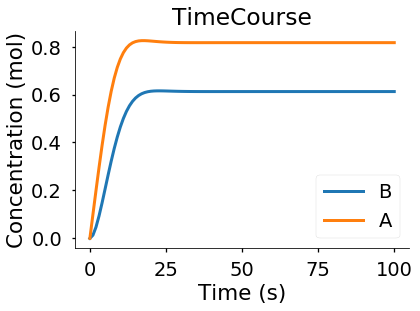

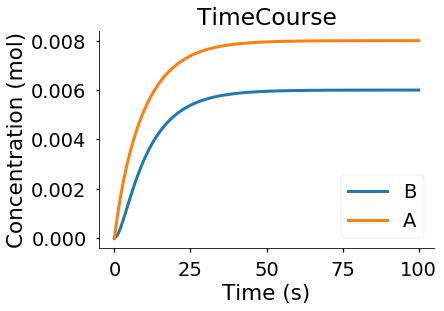

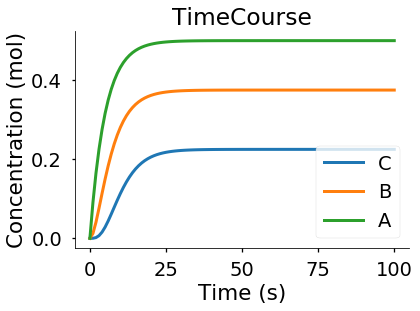

In [2]:
for mod in [mod1, mod2, mod3]:
    TC = tasks.TimeCourse(mod, end=100, intervals=100, step_size=1)
    viz.PlotTimeCourse(TC, separate=False)

### Simulate Synthetic Data

In [3]:
## Create time course data from negative feedback model
## This data is automatically saved as a report in the 
## same directory as the model
TC = tasks.TimeCourse(mod1, end=100, intervals=10, step_size=10)

## Make sure that the headings inside the data file are
## identical to model variables (and not encloded by '[]'. )
## overwrites data file with new data file without the extra [].
misc.format_timecourse_data(TC.report_name) 

,Time,B,A,kBDeg,kBProd,kADeg,vAProd
0,0,0.000000,0.000000,0.4,0.3,0.2,0.1
1,10,0.464639,0.748359,0.4,0.3,0.2,0.1
2,20,0.613698,0.823275,0.4,0.3,0.2,0.1
3,30,0.613132,0.816723,0.4,0.3,0.2,0.1
4,40,0.612348,0.816455,0.4,0.3,0.2,0.1
5,50,0.612369,0.816496,0.4,0.3,0.2,0.1
6,60,0.612373,0.816497,0.4,0.3,0.2,0.1
7,70,0.612372,0.816497,0.4,0.3,0.2,0.1
8,80,0.612372,0.816497,0.4,0.3,0.2,0.1
9,90,0.612372,0.816497,0.4,0.3,0.2,0.1


### Perform Model Selection
Here we fit each model to the same data set which was simulated from the negative feedback model. We use the genetic algorithm 

In [4]:
MMF = tasks.MultiModelFit(model_selection_dir,
                          method='genetic_algorithm',
                          population_size=30,
                          number_of_generations=60,
                          copy_number=2,
                          pe_number=20,
                          run_mode=True,
                          overwrite_config_file=True,
                          lower_bound=1e-2,
                          upper_bound=1e2)
MMF.write_config_file()
MMF.setup()
MMF.run()

pycotools.tasks:INFO:4204:    project dir is --> /home/b3053674/Documents/Models/2018/03_March/ModelSelectionDemonstration/ModelSelection
pycotools.tasks:INFO:4169:    Creating workspace from project_dir
pycotools.tasks:INFO:4187:    Workspace created
pycotools.tasks:INFO:4150:    Running models from /home/b3053674/Documents/Models/2018/03_March/ModelSelectionDemonstration/ModelSelection/negative_feedback/MultipleParameterEstimationResults
pycotools.tasks:INFO:3698:    running model: 0
pycotools.tasks:INFO:3698:    running model: 1
pycotools.tasks:INFO:4150:    Running models from /home/b3053674/Documents/Models/2018/03_March/ModelSelectionDemonstration/ModelSelection/positive_feedback/MultipleParameterEstimationResults
pycotools.tasks:INFO:3698:    running model: 0
pycotools.tasks:INFO:3698:    running model: 1
pycotools.tasks:INFO:4150:    Running models from /home/b3053674/Documents/Models/2018/03_March/ModelSelectionDemonstration/ModelSelection/feedforward/MultipleParameterEstimati

### Calculate and Plot Model Selection Criteria 
Models are compared using violin plots which can be saved to file using the `savefig=True` argument. 
In a violin plot:
* The central spot is the median of the distribution
* The thin line down the middle represents the 95% confidence interval
* The thick centeral line represents the interquartile range
* The width of the violin is a kernel density estimation representing the shape of the data

pycotools.viz:INFO:3598:    Violin plot saved to : "/home/b3053674/Documents/Models/2018/03_March/ModelSelectionDemonstration/ModelSelection/ModelSelectionGraphs/ViolinPlot_RSS.png"
pycotools.viz:INFO:3598:    Violin plot saved to : "/home/b3053674/Documents/Models/2018/03_March/ModelSelectionDemonstration/ModelSelection/ModelSelectionGraphs/ViolinPlot_AICc.png"
pycotools.viz:INFO:3598:    Violin plot saved to : "/home/b3053674/Documents/Models/2018/03_March/ModelSelectionDemonstration/ModelSelection/ModelSelectionGraphs/ViolinPlot_BIC.png"
pycotools.viz:INFO:3433:    model selection data saved to /home/b3053674/Documents/Models/2018/03_March/ModelSelectionDemonstration/ModelSelection/ModelSelectionGraphs/ModelSelectionCriteria.csv


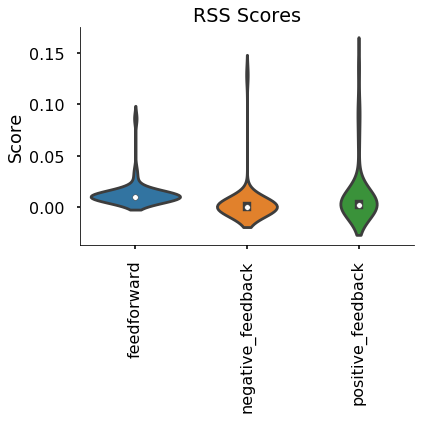

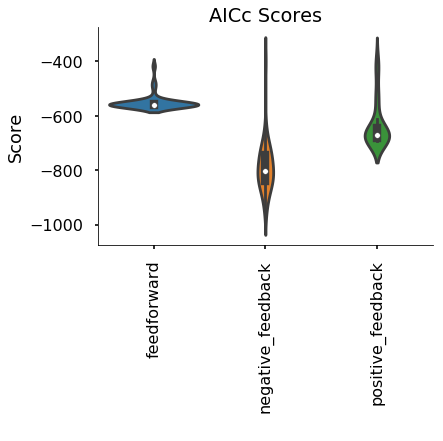

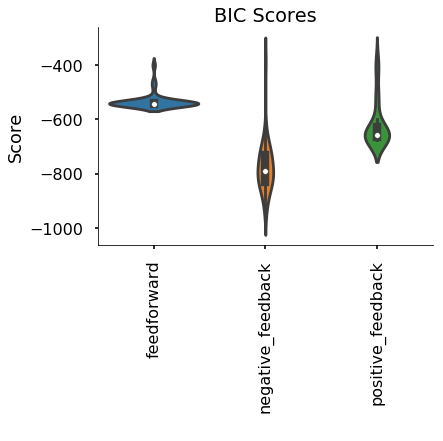

In [5]:
## Automatically produces Violin Plots and saves a 
## csv file containing model selection criteria
MS = viz.ModelSelection(MMF, savefig=True)

Model selection criteria is also available from the `ModelSelection.model_selection_data` attribute.

In [12]:
MS.model_selection_data.head()

feedforward                         negative_feedback              \
                 RSS        AICc         BIC               RSS        AICc   
RSS Rank                                                                     
0           0.009858 -560.401493 -543.694600          0.000030 -949.772247   
1           0.009884 -560.231125 -543.524232          0.000044 -926.074610   
2           0.009919 -559.996353 -543.289461          0.000069 -895.459513   
3           0.009920 -559.986040 -543.279148          0.000074 -891.606848   
4           0.009921 -559.979255 -543.272362          0.000079 -887.192026   

                     positive_feedback                          
                 BIC               RSS        AICc         BIC  
RSS Rank                                                        
0        -937.634319          0.001496 -690.824749 -676.497166  
1        -913.936682          0.001518 -689.865863 -675.538280  
2        -883.321584          0.001525 -689.576998 -675.249414  
3        -879.468919          0.001538 -689.001316 -674.673733  
4        -875.054098          0.001580 -687.236097 -672.908514

### Best Parameters
Original Parameters were:
    
    * A = 0
    * B = 0
    * kADeg = 0.2
    * kBDeg = 0.4
    * kBProd = 0.3
    * vAProd = 0.1


Best estimated parameters for negative feedback model were:

In [7]:
## get key for negative feedback model
MMF.keys()

['/home/b3053674/Documents/Models/2018/03_March/ModelSelectionDemonstration/ModelSelection/negative_feedback/negative_feedback.cps',
 '/home/b3053674/Documents/Models/2018/03_March/ModelSelectionDemonstration/ModelSelection/positive_feedback/positive_feedback.cps',
 '/home/b3053674/Documents/Models/2018/03_March/ModelSelectionDemonstration/ModelSelection/feedforward/feedforward.cps']

In [8]:
## Parse parameter estimation data into pandas.DataFrame
negetive_feedback_MPE = MMF['/home/b3053674/Documents/Models/2018/03_March/ModelSelectionDemonstration/ModelSelection/negative_feedback/negative_feedback.cps']
data = viz.Parse(negetive_feedback_MPE).data
data.iloc[0]

A         0.012177
B         0.011752
kADeg     0.202126
kBDeg     0.398976
kBProd    0.301419
vAProd    0.100330
RSS       0.000030
Name: 0, dtype: float64

### Interpretation
As expected, the RSS, AICc and BIC all support the negative feedback model as the model which best fits the data.

### Subsequent Analysis
The `tasks.MultiModelFit` object is a container object much like a dictionary for a series of `tasks.MultiParameterEstimation` objects. You can iterate over the `tasks.MultiModelFit` object to get a handle on each of the `tasks.MultiParameterEstimation` objects. Classes in the `viz` module can then be used to inspect the estimations. 

#### Ensemble Time Courses

pycotools.viz:INFO:1515:    Plotting "B"


/home/b3053674/anaconda2/envs/pycotools/lib/python2.7/site-packages/seaborn-0.8.1-py2.7.egg/seaborn/timeseries.py:184: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



pycotools.viz:INFO:1515:    Plotting "A"
pycotools.viz:INFO:1515:    Plotting "B"
pycotools.viz:INFO:1515:    Plotting "A"
pycotools.viz:INFO:1515:    Plotting "C"
pycotools.viz:INFO:1515:    Plotting "B"
pycotools.viz:INFO:1515:    Plotting "A"


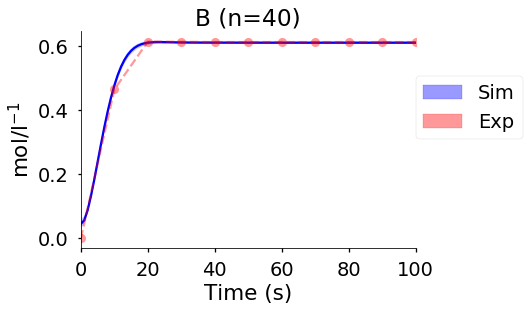

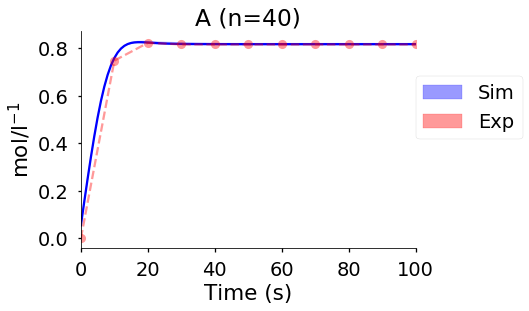

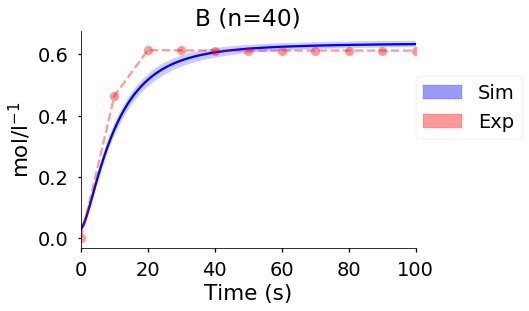

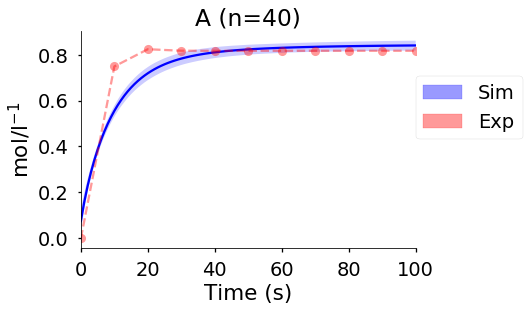

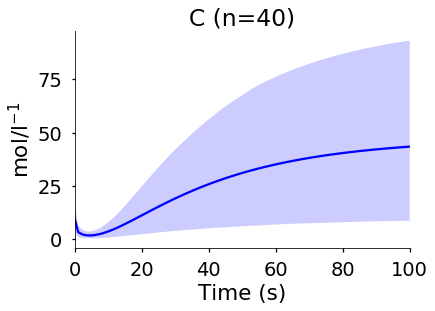

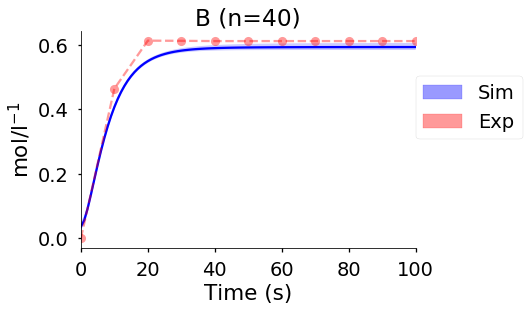

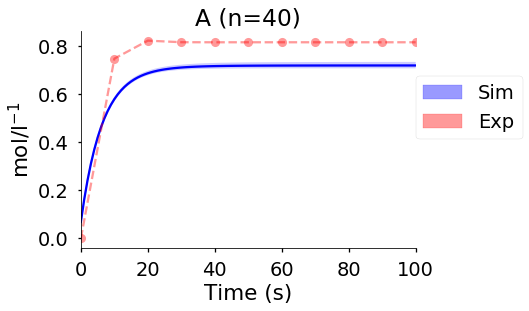

In [9]:
for MPE in MMF:
    viz.PlotTimeCourseEnsemble(MPE, y=[i.name for i in MPE.model.metabolites])

#### Likelihood ranks

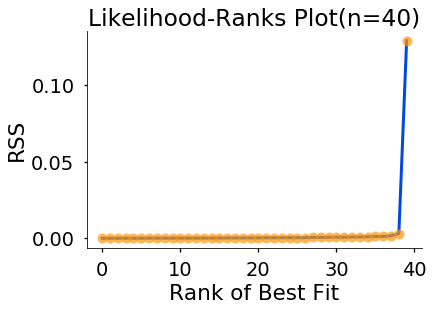

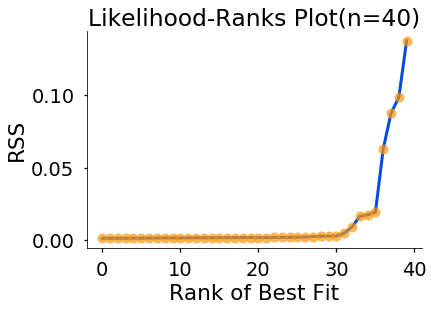

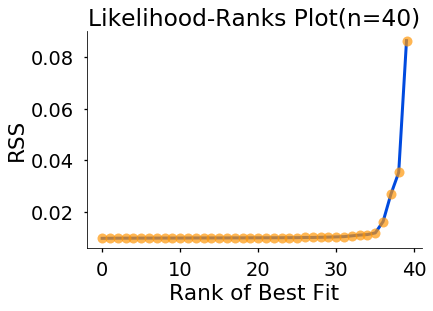

In [10]:
for MPE in MMF:
    viz.LikelihoodRanks(MPE)

#### Boxplots

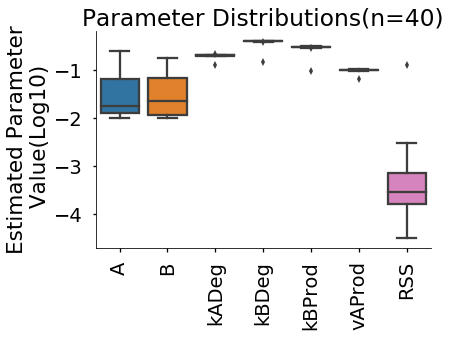

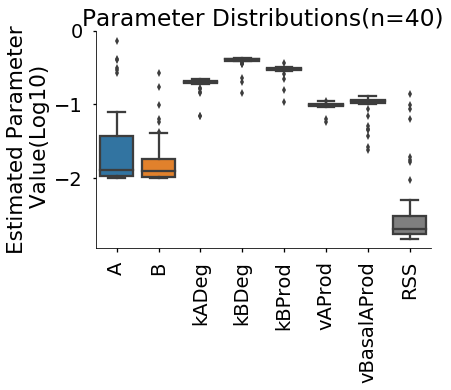

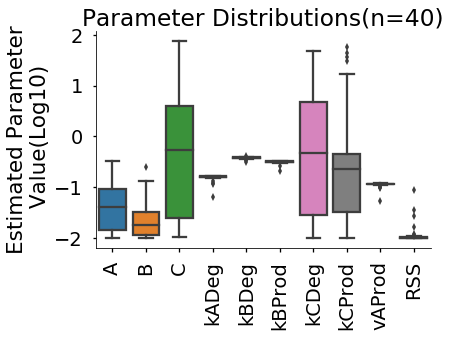

In [11]:
for MPE in MMF:
    viz.Boxplots(MPE, num_per_plot=10, log10=True)